In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **Imports**

In [27]:
import torch 
import numpy
import torchmetrics
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torch import nn
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

Accuracy = torchmetrics.Accuracy(task='multiclass',num_classes=4).to(device)


cuda


### **Inspecting Images**

In [28]:
data_path = Path("/kaggle/input/brain-tumor-mri-dataset/")
train_dir = data_path /'Training'
test_dir = data_path/ 'Testing'

In [29]:
test_dir

PosixPath('/kaggle/input/brain-tumor-mri-dataset/Testing')

meningioma
Random image path: /kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0341.jpg
Image class: meningioma
Image height: 512
Image width: 512


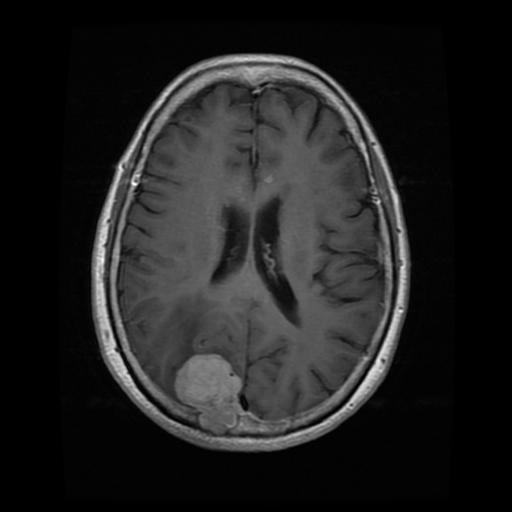

In [30]:
image_path_list = list(train_dir.glob("*/*.jpg"))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img


In [31]:
# Convert the image to a numpy array
img_as_array = np.asarray(img)
img_as_array.shape

(512, 512, 3)

### **Assigning transforms**

In [32]:
img_transforms = transforms.Compose([
    transforms.Resize(size= (128,128)),
    transforms.ToTensor()
])

In [33]:
img_transforms(img)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

### **Loading in Image Data**

In [34]:
train_data = datasets.ImageFolder(root =train_dir,
                                  transform = img_transforms,
                                  target_transform = None)

test_data = datasets.ImageFolder(root =test_dir,
                                 transform = img_transforms
                                 )

In [35]:
train_data

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /kaggle/input/brain-tumor-mri-dataset/Training
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [36]:
class_dict = train_data.class_to_idx
class_dict

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [37]:
class_names = train_data.classes
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [38]:
img.size

(512, 512)

In [39]:
img,label = train_data[170][0], train_data[170][1]
print(f"Img size:{img.shape}")
print(f"Img as tensor: {np.asarray(img)}")
print(f"Label: {label}")
print(f"label type: {type(label)}")

Img size:torch.Size([3, 128, 128])
Img as tensor: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Label: 0
label type: <class 'int'>


Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'glioma')

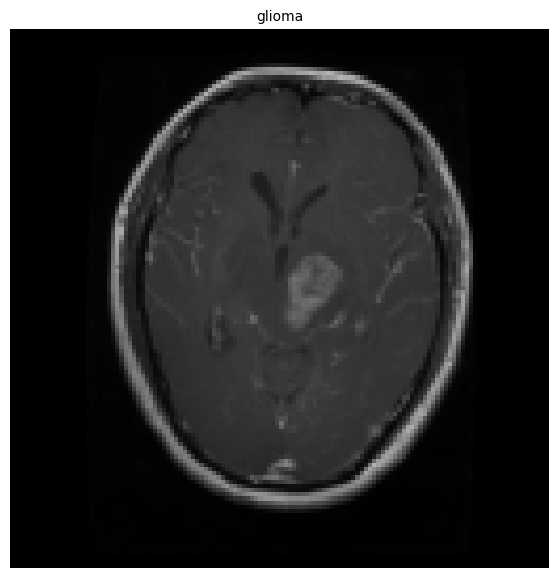

In [40]:
#the image tensor has to be permuted to match the matplotlib requirement of [height, width, color channels]
img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize =10)

### **Assigning DataLoaders**

In [49]:
BATCH_SIZE = 128

train_dataloader = DataLoader(train_data,batch_size = BATCH_SIZE,shuffle=True)
test_dataloader  = DataLoader(test_data,batch_size = BATCH_SIZE, shuffle = False)

### **Model Subclassing**

In [50]:
class BrainClassifier(nn.Module):
    def __init__(self, input_dim,output_dim,hidden_dim):
        super(BrainClassifier,self).__init__()
        
        self.Seq1 = nn.Sequential(
            nn.Conv2d(in_channels = input_dim, out_channels=hidden_dim,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_dim, out_channels=hidden_dim,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=2,kernel_size=2)
        )
        
        self.Seq2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_dim, out_channels=hidden_dim,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_dim, out_channels=hidden_dim,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=2,kernel_size=2)
        )
        self.Seq3 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_dim, out_channels=hidden_dim,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_dim, out_channels=hidden_dim,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=2,kernel_size=2)
        )
        self.Seq4= nn.Sequential(
            nn.Conv2d(in_channels = hidden_dim, out_channels=hidden_dim,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_dim, out_channels=hidden_dim,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=2,kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_dim*4*4,out_features=output_dim)
        )
        
    def forward(self, x :torch.Tensor):
        
        x = self.Seq1(x)
        #print(x.shape)
        x = self.Seq2(x)
        #print(x.size())
        x = self.Seq3(x)
        #print(x.size())
        x = self.Seq4(x)
        #print(x.size())
        x = self.classifier(x)
        
        return x
        
        

In [51]:
model = BrainClassifier(input_dim=3,output_dim=4, hidden_dim =128).to(device)

In [52]:
from torchinfo import summary
summary(model, input_size=[32, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
BrainClassifier                          [32, 4]                   --
├─Sequential: 1-1                        [32, 128, 62, 62]         --
│    └─Conv2d: 2-1                       [32, 128, 126, 126]       3,584
│    └─ReLU: 2-2                         [32, 128, 126, 126]       --
│    └─Conv2d: 2-3                       [32, 128, 124, 124]       147,584
│    └─ReLU: 2-4                         [32, 128, 124, 124]       --
│    └─MaxPool2d: 2-5                    [32, 128, 62, 62]         --
├─Sequential: 1-2                        [32, 128, 29, 29]         --
│    └─Conv2d: 2-6                       [32, 128, 60, 60]         147,584
│    └─ReLU: 2-7                         [32, 128, 60, 60]         --
│    └─Conv2d: 2-8                       [32, 128, 58, 58]         147,584
│    └─ReLU: 2-9                         [32, 128, 58, 58]         --
│    └─MaxPool2d: 2-10                   [32, 128, 29, 29]         

### **Training and Testing step**

In [53]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss,train_acc = 0,0
    for batch, (X,y) in enumerate(data_loader):
        
        X,y = X.to(device),y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred,y)

        train_loss+= loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

        train_acc += Accuracy(y_pred_class,y)

    train_loss = train_loss / len(data_loader)
    train_acc = train_acc / len(data_loader)
    return train_loss, train_acc

In [54]:
def test_step(model: torch.nn.Module, 
              data_loader: torch.utils.data.DataLoader, #type: ignore
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(data_loader):  
            
            X,y = X.to(device),y.to(device)
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += Accuracy(test_pred_labels,y)
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(data_loader)
    test_acc = test_acc / len(data_loader)
    return test_loss, test_acc

In [55]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, # type: ignore 
          test_dataloader: torch.utils.data.DataLoader, # type: ignore 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


In [70]:
# Set random seeds

NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2212 | train_acc: 0.9230 | test_loss: 0.3216 | test_acc: 0.8741
Epoch: 2 | train_loss: 0.2121 | train_acc: 0.9264 | test_loss: 0.3169 | test_acc: 0.8741
Epoch: 3 | train_loss: 0.2094 | train_acc: 0.9243 | test_loss: 0.3168 | test_acc: 0.8706
Epoch: 4 | train_loss: 0.2071 | train_acc: 0.9263 | test_loss: 0.3149 | test_acc: 0.8727
Epoch: 5 | train_loss: 0.2046 | train_acc: 0.9277 | test_loss: 0.3104 | test_acc: 0.8777
Total training time: 226.658 seconds


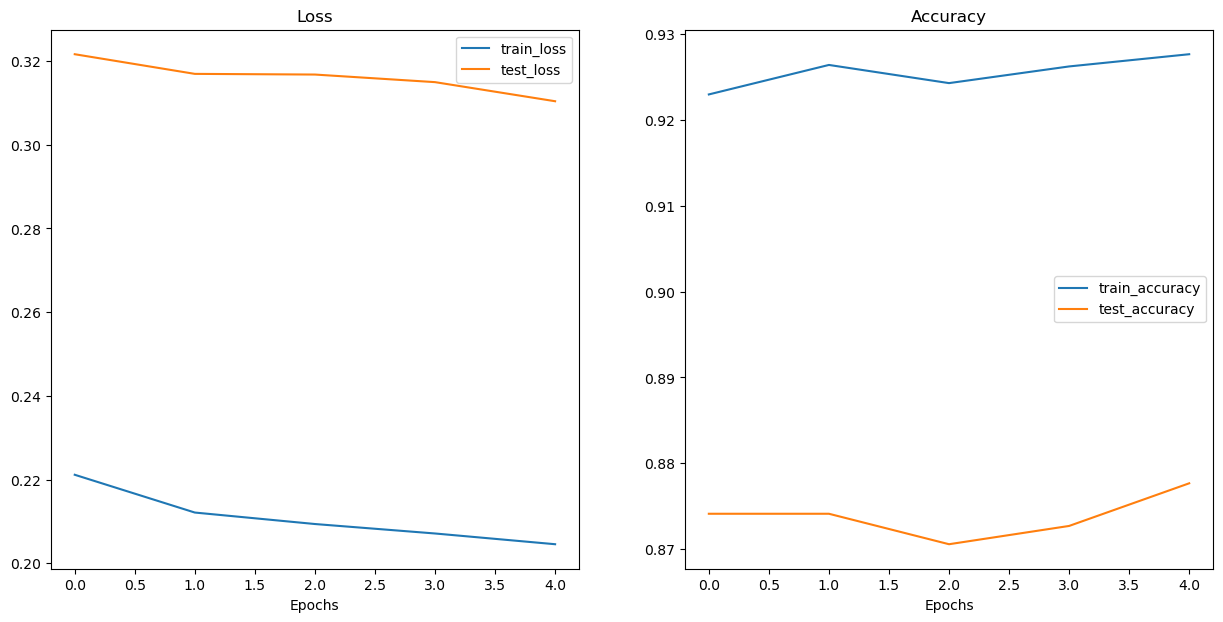

In [76]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = torch.tensor(results['train_loss']).cpu()
    test_loss = torch.tensor(results['test_loss']).cpu()

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = torch.tensor(results['train_acc']).cpu()
    test_accuracy = torch.tensor(results['test_acc']).cpu()

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_0_results)
# Note that this graph was plotted against the last round of epochs 

In [79]:
model_0_results

{'train_loss': [0.2211500952641169,
  0.21212543696165084,
  0.20938416057162815,
  0.20712258203162087,
  0.20455804864565533],
 'train_acc': [tensor(0.9230, device='cuda:0'),
  tensor(0.9264, device='cuda:0'),
  tensor(0.9243, device='cuda:0'),
  tensor(0.9263, device='cuda:0'),
  tensor(0.9277, device='cuda:0')],
 'test_loss': [0.3216112069785595,
  0.3169163946400989,
  0.31675515933470294,
  0.31494232334873895,
  0.31038124063475564],
 'test_acc': [tensor(0.8741, device='cuda:0'),
  tensor(0.8741, device='cuda:0'),
  tensor(0.8706, device='cuda:0'),
  tensor(0.8727, device='cuda:0'),
  tensor(0.8777, device='cuda:0')]}

This model currently sits a Training Accuracy of 0.9277 and a Testing Accuracy of 0.8777

In [82]:
torch.save(model.state_dict(),f ='/kaggle/working/model_state_dict.pt' )